In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

C:\Users\atami\anaconda3\envs\jcopml\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv("data/house_price.csv", index_col="ID")
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
ID,,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [3]:
X = df.drop(columns="medv")
y = df.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((266, 13), (67, 13), (266,), (67,))

In [4]:
df.isna().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

In [5]:
X_train.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat'],
      dtype='object')

In [6]:
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp
from sklearn.ensemble import RandomForestRegressor

In [8]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat']),
    ('categoric', cat_pipe(), ['chas']),
    # we don.t have to encode bcs chas is 1 / 0
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])


parameter = {
    'algo__n_estimators': [100, 150, 200],
     'algo__max_depth': [20, 50, 80],
     'algo__max_features': [0.3, 0.6, 0.8],
     'algo__min_samples_leaf': [1, 5, 10]
}


model = GridSearchCV(pipeline, parameter, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
{'algo__max_depth': 20, 'algo__max_features': 0.6, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 200}
0.9789454334689734 0.8394425941403533 0.9124500246015383


## Features Importance

### jcop ml features importances (mean loss decrease)

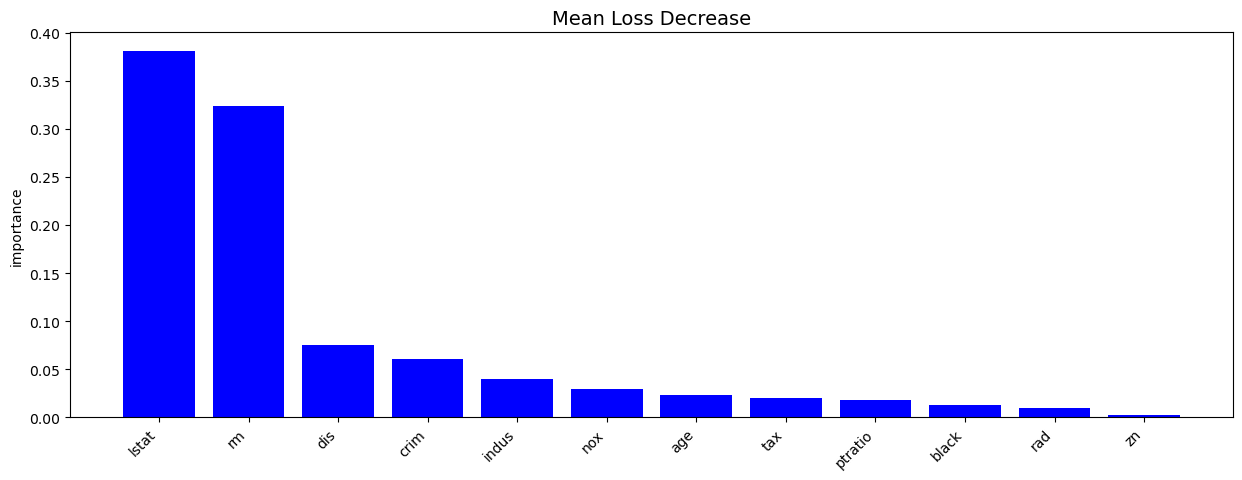

In [21]:
from jcopml.feature_importance import mean_loss_decrease
import matplotlib.pyplot as plt

df_imp = mean_loss_decrease(X_train, model, plot=True, topk=12)

### sklearn feature importances (permutation importance)

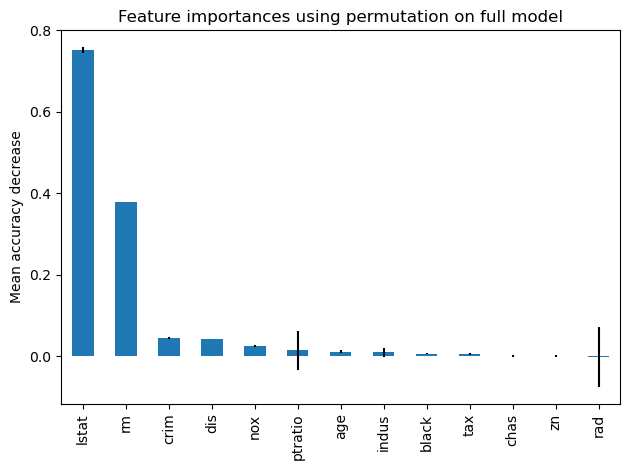

In [37]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

forest_importances = pd.Series(result.importances_mean, index=['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat'])

fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [38]:
forest_importances.sort_values(ascending=False)

lstat      0.751486
rm         0.378962
crim       0.045291
dis        0.043352
nox        0.025326
ptratio    0.014711
age        0.012093
indus      0.010089
black      0.007097
tax        0.005636
chas       0.000909
zn         0.000556
rad       -0.000722
dtype: float64

# Prediction

In [43]:
X_train.iloc[:1]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
ID,,,,,,,,,,,,,
340,0.05497,0.0,5.19,0,0.515,5.985,45.4,4.8122,5,224,20.2,396.9,9.74


In [54]:
X_pred = pd.DataFrame([[0.01,50,3,1,0.8,3,20,4,1,300,10,400,5]], columns=X_train.columns)
X_pred

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.01,50,3,1,0.8,3,20,4,1,300,10,400,5


In [48]:
model.predict(X_pred)

array([25.701])

# Save Model

In [49]:
import pickle, os

os.makedirs("Models", exist_ok=True)

filename = "Models/RF_House_Price.pkl"
pickle.dump(model.best_estimator_, open(filename, "wb"))

# Load Model

In [56]:
loaded_model = pickle.load(open("Models/RF_House_Price.pkl", 'rb'))

X_pred = pd.DataFrame([[0.01,50,3,1,0.8,3,20,4,1,300,10,400,5]], columns=X_train.columns)
loaded_model.predict(X_pred)

array([25.701])